<a href="https://colab.research.google.com/github/ALMerrill/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ALMerrill/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 30% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available()

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

* CrossEntropyLoss 
* Conv2D

**DONE:**

* Conv2D
___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform

**DONE:**



In [0]:
def Xe(data):
  pass

def orthogonal(data):
  pass

def uniform(data, lower, upper):
  data.uniform_(lower, upper)
  

class Conv2d(nn.Module):
  def __init__(self, n_channels, out_channels, kernel_size, stride=1, 
               padding=0, dilation=1, groups=1, 
               bias=True, initialization=uniform):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()
    
    self.weight = Parameter(torch.Tensor(out_channels, 
                               n_channels,
                               *kernel_size))
    initialization(self.weight.data, -1, 1)
    
    self.bias = Parameter(torch.Tensor(out_channels))
    initialization(self.bias.data, 0, 0)
    
  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, 
                    self.padding, self.dilation, self.groups)
  
def oneHotEncode(y):
  y = y.numpy()
  y_onehot = np.zeros((y.size, 10))
  y_onehot[np.arange(y.size), y] = 1

class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
    super(CrossEntropyLoss, self).__init__()
  
  def forward():
    maxes, _ = torch.max(y_hat, 1, keepdim=True) #Log sum x trick to prevent overflow
    y_hat = y_hat - maxes
    y_hat = torch.exp(y_hat)
    y_hat = y_hat / torch.sum(y_hat, 1, keepdim=True)
    return -torch.sum((troch.mul(y_truth.float(), torch.log(y_hat).float()))) #actual cross entropy loss part after the trick
  


In [0]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10
    dim1 = 50
    dim2 = 25
    dim3 = 40
    image_size = (28,28)
    self.net = nn.Sequential(
        Conv2d(c, dim1, (3,3), padding=(1,1), initialization=uniform),
        nn.ReLU(),
        Conv2d(dim1, dim2, (3,3), padding=(1,1), initialization=uniform),
        nn.ReLU(),
        Conv2d(dim2, dim3, (3,3), padding=(1,1), initialization=uniform),
        nn.ReLU(),
        Conv2d(dim3, output, (28,28), padding=(0,0), initialization=uniform)
    )
  
  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)

transform = transforms.ToTensor()
  
  
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, 
                                      train=train, 
                                      transform=transform, 
                                      download=True)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y
  
  def __len__(self):
    return len(self.data)

In [0]:
  
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)
model = ConvNetwork(train_dataset)
model = model.cuda()
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = DataLoader(train_dataset,
                         batch_size=20,
                         pin_memory=True)
val_loader = DataLoader(val_dataset,
                       batch_size=20,
                       pin_memory=True)

data_loaders = {'train': train_loader, 'val': val_loader}

losses = []
validations = []


## Training

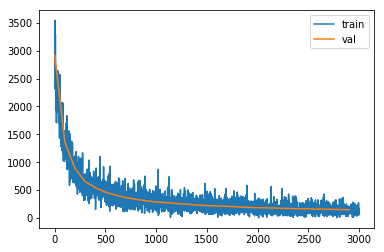

In [0]:
EPOCHS = 500


for epoch in range(EPOCHS):
  loop = tqdm(total=len(train_loader), position=0, leave=False)
  
  for batch, (x, y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    optimizer.zero_grad()
    y_hat = model(x)
    
    loss = objective(y_hat, y_truth)
    loss.backward()
    
    losses.append(loss.item())
    accuracy = (y_hat.argmax(1) == y_truth).float().mean()              
    #### Just plot the accuracy of each batch? Or running accuracy? Or something else?
    
    
    loop.set_description('epoch: {}, loss: {:.4f}, accuracy: {:.3f}'
                         .format(epoch, loss, accuracy))
    loop.update(1)
    
    optimizer.step()
    
    if batch % 100 == 0:
      val = np.mean([objective(model(x.cuda()), y.cuda()).item() 
                     for x, y in val_loader])
      validations.append((len(losses), val))
  loop.close()
  break
  
a, b = zip(*validations)
plt.plot(losses, label='train')
plt.plot(a,b, label='val')
plt.legend()
plt.show()

In [0]:
# model = ConvNetwork(train_dataset)
# model.net[0].weight.data.uniform_(-1,1)
# model.net[0].weight

a = torch.from_numpy(np.random.randn(3,10,1).astype(np.float32))

b = torch.exp(a)

z = a / b.sum(1, keepdim=True)

#indeces wanted from batches (i[0] says it wants the i[o] index from the first batch, and so on)
i = y_truth[:3]
row = torch.arange(b.size(0)) # tensor([0, 1, 2]
col = i # tensor([3, 2, 4]
b[row, col].mean()



# # first batch
# print(b[0])

# # first index of each batch
# print(b[:,0])


tensor([[0.3060],
        [0.6013],
        [2.6325],
        [1.4179],
        [0.9850],
        [7.1304],
        [1.7246],
        [0.8546],
        [0.6553],
        [0.2452]])
tensor([[0.3060],
        [0.2126],
        [0.3982]])


(tensor([0, 1, 2]), tensor([3, 2, 4], device='cuda:0'))


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model 

**DONE:**


In [0]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy



In [0]:
# Compute and print the number of parameters in the model

num_params = sum(p.numel() for p in model.parameters())
num_params

334425

___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3,3), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **Your answer in bold here**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**

**TODO:**

* Answer all the questions above 

**DONE:**


In [0]:
output_dim = input_dim - kernel_size + 1

O = ((I - K + 2P) / s) + 1
output = ((input_dim - kernel_size + 2*padding) / stride) + 1

# Write some test code for checking the answers for these problems (example shown in the video)
#Example
c = nn.Conv2d(3, 10, kernel_size=(3,3), padding=(0,0))
c(torch.zeros(1, 3, 10, 10)).size()

# 3x3 kernels
c = nn.Conv2d(3, 10, kernel_size=(3,3), padding=(0,0))
c(torch.zeros(1, 3, 10, 10)).size()

c = nn.Conv2d(3, 10, kernel_size=(3,3), padding=(0,0))
c(torch.zeros(1, 3, 10, 10)).size()

c = nn.Conv2d(3, 10, kernel_size=(3,3), padding=(0,0))
c(torch.zeros(1, 3, 10, 10)).size()

c = nn.Conv2d(3, 10, kernel_size=(3,3), padding=(0,0))
c(torch.zeros(1, 3, 10, 10)).size()

# 5x5 kernels

# 5x3 kernels

# Smallest padding size

torch.Size([1, 10, 8, 8])